# Exercise 1: Business cycle correlations

For this exercise, you'll be using macroeconomic data from the folder `data/FRED`.

1.  There are seven decade-specific files named `FRED_monthly_YYYY.csv` where `YYYY` identifies the decade by its first year (`YYYY` takes on the values 1950, 1960, ..., 2010). Write a loop that reads in all seven files as DataFrames and store them in a list.

    *Hint:* Recall from the lecture that you should use `pd.read_csv(..., parse_dates=['DATE'])` to automatically parse strings stored in the `DATE` column as dates.
2.  Use [`pd.concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) to concate these data sets into a single `DataFrame` and set the `DATE` column as the index.
3.  You realize that your data does not include GDP since this variable is only reported at quarterly frequency.
    Load the GDP data from the file `GDP.csv` and merge it with your monthly data using an _inner join_.
4.  You want to compute how (percent) changes of the variables in your data correlate with percent changes in GDP.

    1. Create a _new_ `DataFrame` which contains the percent changes in CPI and GDP (using 
    [`pct_change()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html),
    and the absolute changes for the remaining variables (using 
    [`diff()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html)).
    2.  Compute the correlation of the percent changes in GDP with the (percent) changes of all other variables using [`corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html). What does the sign and magnitude of the correlation coefficient tell you?



## Solution

#### Part 1: Loading the data

In [1]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data/FRED'

# Uncomment this to load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/TECH2-H25/main/data/FRED'

There are many ways to load the seven files we need. Once possibility is to loop over the decades 1950, 1960, ..., construct the decade-specific file name and load the decade-specific file.

In [2]:
import numpy as np
import pandas as pd
import os.path

# Create years representing decades: 1950, 1960, ....
years = np.arange(1950, 2011, 10)

data = []
for year in years:
    # File name for current decade
    fn = f'FRED_monthly_{year}.csv'

    # Join data folder + filename to get path to CSV file
    path = os.path.join(DATA_PATH, fn)

    print(f'Loading data from: {path}')
    
    # Load decade data
    df = pd.read_csv(path, parse_dates=['DATE'])
    
    data.append(df)

Loading data from: ../../data/FRED/FRED_monthly_1950.csv
Loading data from: ../../data/FRED/FRED_monthly_1960.csv
Loading data from: ../../data/FRED/FRED_monthly_1970.csv
Loading data from: ../../data/FRED/FRED_monthly_1980.csv
Loading data from: ../../data/FRED/FRED_monthly_1990.csv
Loading data from: ../../data/FRED/FRED_monthly_2000.csv
Loading data from: ../../data/FRED/FRED_monthly_2010.csv


#### Part 2: Concatenating data

In [3]:
# Concatenate decade data along the row axis
df = pd.concat(data, axis=0)

# Print first 5 observations
df.head(5)

,DATE,CPI,UNRATE,FEDFUNDS,REALRATE,LFPART
0,1950-01-01,23.5,6.5,NaN,NaN,58.9
1,1950-02-01,23.6,6.4,NaN,NaN,58.9
2,1950-03-01,23.6,6.3,NaN,NaN,58.8
3,1950-04-01,23.6,5.8,NaN,NaN,59.2
4,1950-05-01,23.8,5.5,NaN,NaN,59.1


In [4]:
# Print last 5 observations
df.tail(5)

,DATE,CPI,UNRATE,FEDFUNDS,REALRATE,LFPART
115,2019-08-01,256.0,3.6,2.1,0.6,63.1
116,2019-09-01,256.4,3.5,2.0,0.3,63.2
117,2019-10-01,257.2,3.6,1.8,-0.0,63.3
118,2019-11-01,257.9,3.6,1.6,-0.2,63.3
119,2019-12-01,258.6,3.6,1.6,-0.3,63.3


The index in the concatenated data is not unique, as you can easily verify:

In [5]:
# Selecting the obs with label 0 returns 7 rows!
df.loc[0]

,DATE,CPI,UNRATE,FEDFUNDS,REALRATE,LFPART
0,1950-01-01,23.5,6.5,NaN,NaN,58.9
0,1960-01-01,29.4,5.2,4.0,NaN,59.1
0,1970-01-01,37.9,3.9,9.0,NaN,60.4
0,1980-01-01,78.0,6.3,13.8,NaN,64.0
0,1990-01-01,127.5,5.4,8.2,3.8,66.8
0,2000-01-01,169.3,4.0,5.4,2.7,67.3
0,2010-01-01,217.5,9.8,0.1,-0.8,64.8


It is advisable to always work with a unique index in pandas, and for this data set the most natural unique index is the date.

In [6]:
# Set DATE column as index
df = df.set_index('DATE')

#### Part 3: Merging GDP

In [7]:
# Path to GDP data
fn = os.path.join(DATA_PATH, 'GDP.csv')

# Load GDP data
gdp = pd.read_csv(fn, parse_dates=['DATE'], index_col='DATE')

gdp.head(5)

,GDP
DATE,
1947-01-01,2182.7
1947-04-01,2176.9
1947-07-01,2172.4
1947-10-01,2206.5
1948-01-01,2239.7


We merge the GDP using an _inner join_, which discards all months where GDP is not reported.

In [8]:
# Merge the GDP data using an inner join
df = df.join(gdp, how='inner')

df.head(5)

,CPI,UNRATE,FEDFUNDS,REALRATE,LFPART,GDP
DATE,,,,,,
1950-01-01,23.5,6.5,NaN,NaN,58.9,2346.1
1950-04-01,23.6,5.8,NaN,NaN,59.2,2417.7
1950-07-01,24.1,5.0,NaN,NaN,59.1,2511.1
1950-10-01,24.5,4.2,NaN,NaN,59.4,2559.2
1951-01-01,25.4,3.7,NaN,NaN,59.1,2594.0


#### Part 4: Correlations

We can compute (percent) changes for multiple columns at once, so there is no need to even loop over variables:

In [9]:
# Compute percent changes for CPI and GDP
df_changes = df[['CPI', 'GDP']].pct_change() * 100

# Other variables for which to compute absolute changes
variables = ['UNRATE', 'FEDFUNDS', 'REALRATE', 'LFPART']

# Compute absolute changes, add to DataFrame
df_changes[variables] = df[variables].diff()

df_changes.head(5)

,CPI,GDP,UNRATE,FEDFUNDS,REALRATE,LFPART
DATE,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,0.425532,3.051873,-0.7,NaN,NaN,0.3
1950-07-01,2.118644,3.863176,-0.8,NaN,NaN,-0.1
1950-10-01,1.659751,1.915495,-0.8,NaN,NaN,0.3
1951-01-01,3.673469,1.359800,-0.5,NaN,NaN,-0.3


The `corr()` method returns the whole (symmetric) correlation matrix. We are only interested in the correlations with GDP changes, so we can select that particular row.

In [10]:
# Compute correlation matrix, keep only GDP row
df_changes.corr().loc['GDP']

CPI        -0.113091
GDP         1.000000
UNRATE     -0.564872
FEDFUNDS    0.206370
REALRATE    0.074500
LFPART      0.019639
Name: GDP, dtype: float64

As we can see, some (changes in) variables are more highly correlated with GDP changes than others. For example, the unemployment rate is highly negatively correlated with GDP growth, i.e., in good times (large positive GDP changes), the unemployment rate drops.

***
# Exercise 2: Loading many data files

In the previous exercise, you loaded the individual files by specifing an explicit list of file names. This can become tedious or infeasible if your data is spread across many files with varying file name patterns. Python offers the possibility to iterate over all files in a directory (for example, using [`os.listdir()`](https://docs.python.org/3/library/os.html#os.listdir)),
or to iterate over files that match a pattern, for example using [`glob.glob()`](https://docs.python.org/3/library/glob.html).

Repeat parts (1) and (2) from the previous exercise, but now iterate over the input files using 
[`glob.glob()`](https://docs.python.org/3/library/glob.html). You'll need to use a wildcard `*` and make sure to match only the relevant files in `data/FRED`, i.e., those that start with `FRED_monthly_1` or `FRED_monthly_2`.

## Solution

In [11]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data/FRED'

# Uncomment this to load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/TECH2-H25/main/data/FRED'

If you are not familiar with more complex patterns used for matching files, one way to solve the problem is as follows:

In [12]:
import pandas as pd 
import glob

# List to hold imported DataFrames
data = []

for i in (1, 2):
    # Specify pattern that matches only relevant files
    pattern = f'{DATA_PATH}/FRED_monthly_{i}*.csv'
    # Iterate over files that match the pattern
    for file in glob.glob(pattern):
        print(f'Loading file {file}')
        d = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')
        data.append(d)

# Concatenate all DataFrames
df = pd.concat(data, axis=0)

# Sort index in case files have been loaded in unexpected order
df = df.sort_index()

Loading file ../../data/FRED/FRED_monthly_1950.csv
Loading file ../../data/FRED/FRED_monthly_1960.csv
Loading file ../../data/FRED/FRED_monthly_1970.csv
Loading file ../../data/FRED/FRED_monthly_1980.csv
Loading file ../../data/FRED/FRED_monthly_1990.csv
Loading file ../../data/FRED/FRED_monthly_2000.csv
Loading file ../../data/FRED/FRED_monthly_2010.csv


However, file matching patterns can be more sophisticated, so you can skip the outer loop as use the following pattern to match monthly files with decades starting either with 1 or 2:

In [13]:
# More sophisticated pattern to match all decades
pattern = f'{DATA_PATH}/FRED_monthly_[12]*.csv'

# List to hold imported DataFrames
data = []

# Iterate over files that match the pattern
for file in glob.glob(pattern):
    print(f'Loading file {file}')
    d = pd.read_csv(file, parse_dates=['DATE'], index_col='DATE')
    data.append(d)

# Concatenate all DataFrames
df = pd.concat(data, axis=0)

# Sort index in case files have been loaded in unexpected order
df = df.sort_index()

Loading file ../../data/FRED/FRED_monthly_1950.csv
Loading file ../../data/FRED/FRED_monthly_1960.csv
Loading file ../../data/FRED/FRED_monthly_1970.csv
Loading file ../../data/FRED/FRED_monthly_1980.csv
Loading file ../../data/FRED/FRED_monthly_1990.csv
Loading file ../../data/FRED/FRED_monthly_2000.csv
Loading file ../../data/FRED/FRED_monthly_2010.csv


***
# Exercise 3: Weekly returns of the magnificent seven

In this exercise, you are asked to analyze the weekly stockmarket returns
of the so-called magnificent 7 which are some of the most successful tech companies 
of the last decades years:
Apple (AAPL), Amazon (AMZN), Alphabet/Google (GOOGL), Meta (META), Microsoft (MSFT), Nvidia (NVDA), and Tesla (TSLA).

The data for this exercise is located in the folder `data/stockmarket/`.

1.  For each of the seven stocks listed above, there is a corresponding 
    CSV file in this directory (based on the ticker symbol).

    1.  For each ticker symbol, load the corresponding CSV file and make sure 
        that the `Date` is set as the index.

        The DataFrame has two columns, `Open` and `Close`, which contain the 
        opening and closing price for each trading day.

    3.  Use [`resample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)
        to resample the daily data to a weekly frequency by specifying `resample('W')`,
        and compute the weekly returns in percent:

        $$
        \text{Weekly returns} = \frac{\text{Close price on last day} - \text{Open price on first day}}{\text{Open price on first day}} \times 100
        $$

        *Hint:* You can obtain the first and last observation using the 
        [`first()`](https://pandas.pydata.org/docs/reference/api/pandas.core.resample.Resampler.first.html) and 
        [`last()`](https://pandas.pydata.org/docs/reference/api/pandas.core.resample.Resampler.last.html)
        methods.

    4.  Append these returns to a list so you can merge them into a single DataFrame later.

2.  Merge the list of weekly returns you computed into a single DataFrame.
    Keep only the intersection of dates available for all 7 stocks.

    *Hint:* This can be achieved using either 
    [`pd.concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html),
    [`pd.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.merge.html), or 
    [`DataFrame.join()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html).

3.  Finally, you are interested in how the weekly returns are correlated across 
    the 7 stocks. 

    1.  Compute and report the pairwise correlations using 
        [DataFrame.corr()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html).

    2.  Create a figure with 7-by-7 subplots showing the pairwise scatter plots of weekly returns 
        for each combination of stocks.

        You can do this either with the
        [`scatter_matrix()`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) function contained in `pandas.plotting`, 
        or manually build the figure using Matplotlib functions.

    3.  **[Advanced]**
        In each of the subplots, add a text that reports the pairwise correlation
        for these stocks which you computed earlier.
        (e.g., the correlation between returns on AAPL and AMZN is about 0.42,
        so this text should be added to the subplot showing the 
        scatter plot of AAPL vs. AMZN).


## Solution

### Part 1: Loading the data and computing weekly returns

In [14]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data/stockmarket'

# Uncomment this to load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/TECH2-H25/main/data/stockmarket'

In [15]:
import pandas as pd

# List of ticker symbols for the 7 stocks
symbols = ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

# List to store weekly returns
returns = []

for symbol in symbols:
    # Load this file and use Date as column index
    filename = f'{DATA_PATH}/{symbol}.csv'
    df = pd.read_csv(filename, parse_dates=['Date'], index_col='Date')

    # Resample to weekly frequency, store first and last prices
    first = df.resample('W')['Open'].first()
    last = df.resample('W')['Close'].last()

    # Compute weekly percentage returns
    ret = (last - first) / first * 100.0

    # Give series the corresponding ticker symbol as name
    ret.name = symbol

    returns.append(ret)


### Part 2

There are many ways to combine the weekly returns data into a single DataFrame. We can even use 
`pd.concat()` if we specify the option `join='inner'` which performs an inner join on the dates:

In [16]:
df_returns = pd.concat(returns, axis=1, keys=symbols, join='inner')

Alternatively, we can use one of the `merge()` or `join()` methods that pandas offers. This is a little trickier since merging only works on two DataFrames at a time, so we need to do this in a loop.

In [17]:
# Store first element and convert it to a DataFrame
df_returns2 = returns[0].to_frame()

# Iteratively merge the other DataFrames. We use join() here since 
# we are merging on the index (dates).
for df in returns[1:]:
    df_returns2 = df_returns2.join(df, how='inner')

The following code verifies that both methods are equivalent:

In [18]:
(df_returns == df_returns2).all()

AAPL     True
AMZN     True
GOOGL    True
META     True
MSFT     True
NVDA     True
TSLA     True
dtype: bool

### Part 3

The pairwise correlation matrix can be computed using the `corr()` method:

In [19]:
# Compute pairwise correlations
corr = df_returns.corr()

# Tabulate correlations
corr

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
AAPL,1.000000,0.421061,0.460413,0.308383,0.505383,0.478437,0.353761
AMZN,0.421061,1.000000,0.567216,0.384163,0.539316,0.464494,0.338082
GOOGL,0.460413,0.567216,1.000000,0.422680,0.591357,0.440485,0.323407
META,0.308383,0.384163,0.422680,1.000000,0.391864,0.333322,0.238438
MSFT,0.505383,0.539316,0.591357,0.391864,1.000000,0.542267,0.343529
NVDA,0.478437,0.464494,0.440485,0.333322,0.542267,1.000000,0.367992
TSLA,0.353761,0.338082,0.323407,0.238438,0.343529,0.367992,1.000000


Recall that the correlation coefficient is normalized onto the interval $[-1, 1]$. A positive value means that two variables co-move in the same direction, whereas the opposite is true for a negative value. An absolute value close to 1 means that this co-movement is particularly strong, whereas values around zero mean that there is almost no co-movement.

The simplest way to plot pairwise correlations is to use 
[`scatter_matrix()`](https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html) from the `pandas.plotting` module as this does all the work for us:

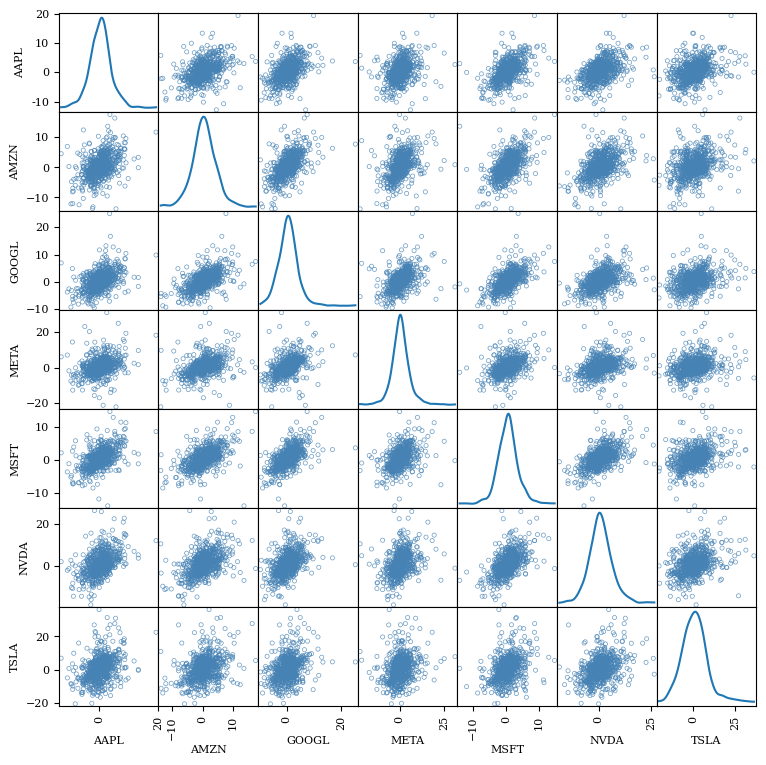

In [20]:
from pandas.plotting import scatter_matrix

# Create figure with 7x7 scatter plots. Main diagonal shows kernel density
# for each index.
axes = scatter_matrix(
    df_returns,
    figsize=(9, 9),
    alpha=0.8,                  # Set transparency of markers
    color='none',               # Color of markers (no filling)
    edgecolors='steelblue',     # Color of marker edges
    lw=0.5,                     # Width of marker edges
    diagonal='kde',             # Add kernel density estimate to diagonal
)

Alternatively, we can create the 7-by-7 subplots manually and plot into each panel using loops.
The following code recreates the 7-by-7 figure from above and adds this pairwise correlation as text to each subplot:

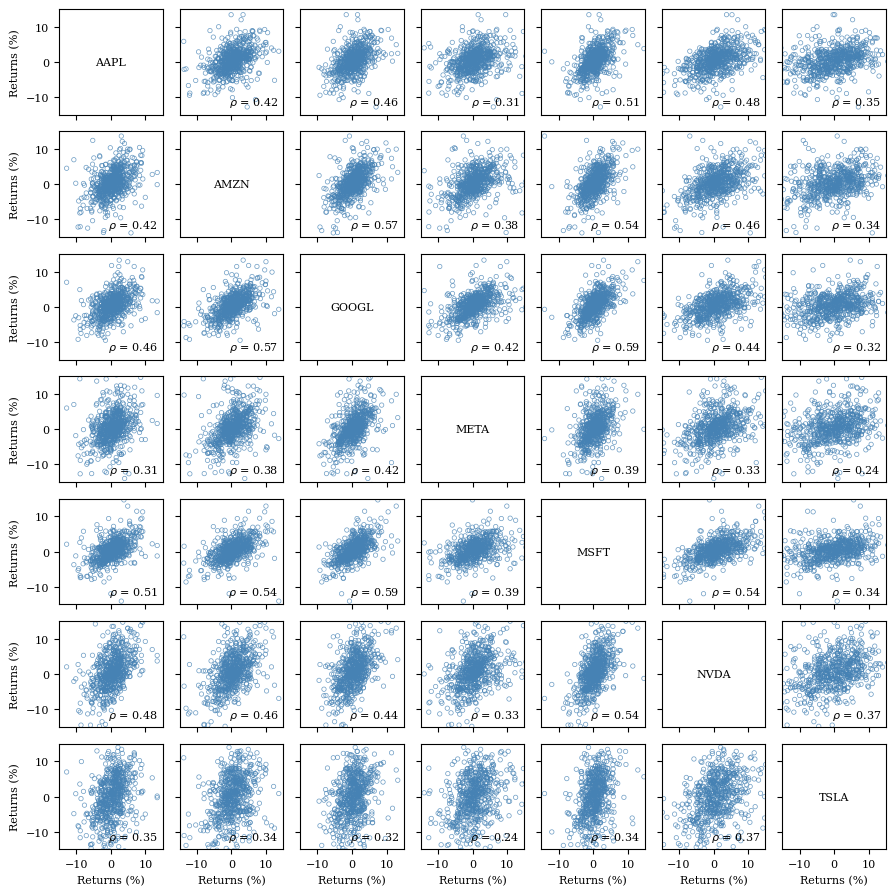

In [21]:
import matplotlib.pyplot as plt

# List of tickers present in DataFrame
tickers = df_returns.columns.to_list()

n = len(tickers)

fig, axes = plt.subplots(n, n, figsize=(9, 9), sharex=True, sharey=True)

# Set range for x- and y-axes
xmin, xmax = -15, 15

# Iterate over rows and columns
for i in range(n):
    for j in range(n):

        # Select current axes
        ax = axes[i, j]

        # Add tick labels to the last row and first column
        if i == n - 1:
            ax.set_xlabel('Returns (%)')
        if j == 0:
            ax.set_ylabel('Returns (%)')

        # For diagonal panels, print the index name instead of
        # (exactly diagonal) scatter plot.
        if i == j:
            ax.text(
                0.5, 0.5, tickers[i], transform=ax.transAxes, va='center', ha='center'
            )
            continue

        # Get x- and y-values for this panel
        xvalues = df_returns.iloc[:, j]
        yvalues = df_returns.iloc[:, i]

        # Create scatter plot
        ax.scatter(
            xvalues,
            yvalues,
            s=10,
            alpha=0.8,
            lw=0.5,
            color='none',
            edgecolors='steelblue',
        )

        # Add text with pairwise correlation
        if i != j:
            ax.text(
                0.95,
                0.05,
                rf'$\rho$ = {corr.iloc[i, j]:.2f}',
                transform=ax.transAxes,
                va='bottom',
                ha='right',
            )

        # Set uniform x- and y-ticks for all axes
        ax.set_xlim((xmin, xmax))
        ax.set_ylim((xmin, xmax))
        ticks = -10, 0, 10
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)


fig.tight_layout()

***
# Exercise 4: Decade averages of macro time series


For this exercise, you'll be using macroeconomic data from the folder `data/FRED`.

1.  There are five files containing monthly observations on annual inflation (INFLATION), the Fed Funds rate (FEDFUNDS), the labor force participation rate (LFPART), the 1-year real interest rate (REALRATE) and the unemployment rate (UNRATE).

    1.  Write a loop to import these files and store the individual DataFrames in a list.

        *Hint:* Recall from the lecture that you should use 
        `pd.read_csv(..., parse_dates=['DATE'], index_col='DATE')` to automatically parse strings stored in the `DATE` column as dates and set the `DATE`
        column as the index.

    2.  Use 
        [`pd.concat()`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)
        to concatenate this list of DataFrames along the column dimension
        using an outer join (`join='outer'`) to obtain a merged data set.

3.  You want to compute the average value of each variable by decade, but you want to include only decades without _any_ missing values for _all_ variables.

    1.  Create a variable `Decade` which stores the decade (1940, 1950, ...) for each observation.

        *Hint:* You should have set the `DATE` as the `DataFrame` index. Then you can access the calendar year using the attribute `df.index.year` which can be used to compute the decade.

    2.  Create an indicator variable which takes on the value `True` 
        whenever all observations (all columns) for a given date are non-missing, and `False`
        if at least one variable has a missing observation. 

    3.  Aggregate this indicator to decades using a
    [`groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) so that the indicator takes on the value `True` whenever
    _all_ variables in a given decade have no missing values, and `False`
    otherwise.

        *Hint:* You can use the 
        [`all()`](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.all.html) aggregation for this.

    4.  Merge this decade-level indicator data back into the original `DataFrame` (_many-to-one_ merge). 
4.  Using this indicator, drop all observations which are in a decade with missing values.
5.  Compute the decade average for each variable.

**Challenge**

-   Your pandas guru friend claims that all the steps in 2.2 to 2.4 can be done with a single one-liner using [`transform()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html). Can you come up with a solution?

    

## Solution

#### Part 1: Loading and merging iteratively

In [22]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data/FRED'

# Uncomment this to load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/TECH2-H25/main/data/FRED'

When using `pd.concat()` to merge files, we first import all the DataFrames and store them in a list, and concatenate all at the end.

In [23]:
import pandas as pd
import os.path

# Variables to be imported
variables = ['INFLATION', 'FEDFUNDS', 'LFPART', 'REALRATE', 'UNRATE']

# List to store individual DataFrames
data = []

for var in variables:
    # File path for current variable
    fn = os.path.join(DATA_PATH, f'{var}.csv')

    # Load data for current variable, parse DATE and set DATE as index
    d = pd.read_csv(fn, parse_dates=['DATE'], index_col='DATE')
    
    data.append(d)

# Concatenate all DataFrames along the column axis. We specify join='outer'
# as we want to perform an outer join along the OTHER (row) axis.
df = pd.concat(data, axis=1, join='outer')

# Print fist 12 rows
df.head(5)

,INFLATION,FEDFUNDS,LFPART,REALRATE,UNRATE
DATE,,,,,
1948-01-01,10.2,NaN,58.6,NaN,3.4
1948-02-01,9.5,NaN,58.9,NaN,3.8
1948-03-01,6.8,NaN,58.5,NaN,4.0
1948-04-01,8.3,NaN,59.0,NaN,3.9
1948-05-01,9.4,NaN,58.3,NaN,3.5


#### Part 2.1: Decade variable

We first need to create a new column `Decade` which stores the decade 1950, 1960, etc., corresponding to each observation.

In [24]:
# Extract calendar year
year = df.index.year 

# Create decade from calendar year using truncated division (could also use np.floor())
decade = (year // 10) * 10

# Assign to new column
df['Decade'] = decade 

# Verify that Decade variable looks as expected
df['Decade'].value_counts()

Decade
1950    120
1990    120
1960    120
1970    120
1980    120
2010    120
2000    120
2020     61
1940     24
Name: count, dtype: int64

#### Part 2.2: Indicator for non-missing observations

In [25]:
# Create indicator for rows with no missing values in the selected variables
no_miss = df[variables].notna().all(axis=1)

no_miss.head(5)

DATE
1948-01-01    False
1948-02-01    False
1948-03-01    False
1948-04-01    False
1948-05-01    False
Freq: MS, dtype: bool

#### Part 2.3: Aggregation to decades

In [26]:
# Create indicator for decades with no missing values
no_miss_decade = no_miss.groupby(df['Decade']).all()

no_miss_decade 

Decade
1940    False
1950    False
1960    False
1970    False
1980    False
1990     True
2000     True
2010     True
2020    False
dtype: bool

#### Part 2.4: Merge indicator into original data

Before merging the missing indicator with the original data, we convert it to a `DataFrame` using 
[`to_frame()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.to_frame.html). This allows us to assign a meaningful column name.

In [27]:
# Convert to DataFrame, assign meaningful column name
no_miss_decade = no_miss_decade.to_frame('NotMissing')

# Reset index to move Decade back into columns
no_miss_decade  = no_miss_decade.reset_index()

no_miss_decade

,Decade,NotMissing
0,1940,False
1,1950,False
2,1960,False
3,1970,False
4,1980,False
5,1990,True
6,2000,True
7,2010,True
8,2020,False


In [28]:
# Merge back into original data set 
df = df.merge(no_miss_decade, how='left', on='Decade')

df.head(5)

,INFLATION,FEDFUNDS,LFPART,REALRATE,UNRATE,Decade,NotMissing
0,10.2,NaN,58.6,NaN,3.4,1940,False
1,9.5,NaN,58.9,NaN,3.8,1940,False
2,6.8,NaN,58.5,NaN,4.0,1940,False
3,8.3,NaN,59.0,NaN,3.9,1940,False
4,9.4,NaN,58.3,NaN,3.5,1940,False


#### Part 3: Dropping missing decades

In [29]:
# Keep only decades without any missing observations
df_no_miss = df.loc[df['NotMissing']].copy()

print(f'Final number of observations: {len(df_no_miss)}')

Final number of observations: 360


#### Part 4: Decade averages

In [30]:
# drop NotMissing, don't want averages of these 
df_no_miss = df_no_miss.drop(columns=['NotMissing'])

# Compute decade means
df_no_miss.groupby('Decade').mean()

,INFLATION,FEDFUNDS,LFPART,REALRATE,UNRATE
Decade,,,,,
1990,3.006667,5.140000,66.668333,2.206667,5.762500
2000,2.568333,2.952500,66.236667,1.023333,5.541667
2010,1.771667,0.618333,63.295000,-0.732500,6.220833


#### Challenge

The pandas guru friend was right, we can use `transform()` and a `lambda` expression to create the indicator by decade and assign it to each observation in one line:

In [31]:
df["NotMissing2"] = (
    df.groupby("Decade").transform(lambda x: x.isna().sum()).sum(axis=1) == 0
)

In [32]:
# Compare original and new indicator to ensure they are the same
(df['NotMissing'] == df['NotMissing2']).all()

np.True_

***
# Exercise 5: Merging additional Titanic data

In this exercise, you'll be working with the the original Titanic data set in `titanic.csv` and additional (partly fictitious) information on passengers stored in `titanic-additional.csv`, both located in the `data/` folder.

The goal of the exercise is to calculate the survival rates by country of residence (for this exercise we restrict ourselves to the UK, so these will be England, Scotland, etc.).

1.  Load the `titanic.csv` and `titanic-additional.csv` into two DataFrames.

    Inspect the columns contained in both data sets. As you can see, the original data contains the full name including the title
    and potentially maiden name (for married women) in a single column.
    The additional data contains this information in separate columns.
    You want to merge these data sets, but you first need to create common keys in both DataFrames.

2.  Since the only common information is the name, you'll need to extract the individual name components from the original DataFrame
    and use these as merge keys.

    Focusing only on men (who have names that are much easier to parse), split the `Name` column into the tokens 
    `Title`, `FirstName` and `LastName`, just like the columns in the second DataFrame.

    *Hint:* This is the same task as in the last exercise in Workshop 2. You can just use your solution here.

3.  Merge the two data sets based on the columns `Title`, `FirstName` and `LastName` you just created using a _left join_ (_one-to-one_ merge).
    Tabulate the columns and the number of non-missing observations to make sure that merging worked. 

    *Note:* The additional data set contains address information only for passengers from the UK, so some of these fields will be missing.

4.  You are now in a position to merge the country of residence (_many-to-one_ merge). Load the country data from `UK_post_codes.csv` which contains 
    the UK post code prefix (which you can ignore), the corresponding city, and the corresponding country.

    Merge this data with your passenger data set using a _left join_ (what is the correct merge key?).

5.  Tabulate the number of observations by `Country`, including the number of observations with missing `Country` (these are passengers residing outside the UK).

    Finally, compute the mean survival rate by country.

## Solution

#### Part 1: Loading the data

In [33]:
# Uncomment this to use files in the local data/ directory
DATA_PATH = '../../data'

# Uncomment this to load data directly from GitHub
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/TECH2-H25/main/data'

Import the original Titanic data:

In [34]:
import pandas as pd 
import os.path

# Path to original data
fn1 = os.path.join(DATA_PATH, 'titanic.csv')

# Read in original data set
df1 = pd.read_csv(fn1, index_col='PassengerId')

# Inspect first 5 rows of the original data set 
df1.head(5)

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss Laina",female,26.0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,NaN,S


Import the additional data:

In [35]:
# Path to additional data
fn2 = os.path.join(DATA_PATH, 'titanic-additional.csv')

# Read in additional data. Note: This one does not have PassengerId
df = pd.read_csv(fn2)

# Inspect 5 rows of the additional data
df.head(5)

,Title,LastName,FirstName,MaidenName,City,Postcode,Address
0,Mr.,Christmann,Emil,NaN,Chester,CH6 34H,3 Graham ways
1,Miss,Heikkinen,Laina,NaN,Bolton,BL0 1XG,0 Griffin wells
2,Lady.,Duff Gordon,Lucille Christiana,Sutherland,NaN,NaN,NaN
3,Miss,Pettersson,Ellen Natalia,NaN,Northampton,NN0 H5R,889 Murray glen
4,Mr.,Odahl,Nils Martin,NaN,Derby,DE7 QZ7,"Studio 2, Long courts"


#### Part 2: Parse individual name components

In [36]:
# Restrict sample to men
df1 = df1.query('Sex == "male"')

In [37]:
# Create DataFrame of name tokens: first column contains the last name,
# second column contains the title and first name
names = df1['Name'].str.split(',', expand=True)

# Trim any residual spaces at the beginning and end
for col in names.columns:
    names[col] = names[col].str.strip()

In [38]:
# Extract the last name from the first column
last_name = names.loc[:, 0]

last_name.head(5)

PassengerId
1      Braund
5       Allen
6       Moran
7    McCarthy
8     Palsson
Name: 0, dtype: object

In [39]:
# Title and first name (potentially multiple) are separated by space.
# partition() splits on the first occurrence of the given character and returns
# three columns.
title_first = names[1].str.strip().str.partition(" ")

title_first.head(5)

,0,1,2
PassengerId,,,
1,Mr.,,Owen Harris
5,Mr.,,William Henry
6,Mr.,,James
7,Mr.,,Timothy J
8,Master,,Gosta Leonard


In [40]:
# Extract title from 1st column, strip any remaining white space
title = title_first[0].str.strip()
title.head(5)

PassengerId
1       Mr.
5       Mr.
6       Mr.
7       Mr.
8    Master
Name: 0, dtype: object

In [41]:
# Extract first name(s) from 3rd column, strip any remaining white space
first_name = title_first[2].str.strip()

# Print first 5 observations
first_name.head(5)

PassengerId
1      Owen Harris
5    William Henry
6            James
7        Timothy J
8    Gosta Leonard
Name: 2, dtype: object

In [42]:
# Add all name components back into original DataFrame
df1['FirstName'] = first_name
df1['LastName'] = last_name
df1['Title'] = title

# Delete Name column
del df1['Name']

In [43]:
df1.head(5)

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FirstName,LastName,Title
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,A/5 21171,7.2500,NaN,S,Owen Harris,Braund,Mr.
5,0,3,male,35.0,373450,8.0500,NaN,S,William Henry,Allen,Mr.
6,0,3,male,NaN,330877,8.4583,NaN,Q,James,Moran,Mr.
7,0,1,male,54.0,17463,51.8625,E46,S,Timothy J,McCarthy,Mr.
8,0,3,male,2.0,349909,21.0750,NaN,S,Gosta Leonard,Palsson,Master


#### Part 3: Merge data sets

In [44]:
# Merge on Title, First name and Last name, keep only left data
keys = ['Title', 'FirstName', 'LastName']
df_merged = df1.merge(df, on=keys, how='left')

In [45]:
# Print missing statistics for merged data
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    577 non-null    int64  
 1   Pclass      577 non-null    int64  
 2   Sex         577 non-null    object 
 3   Age         453 non-null    float64
 4   Ticket      577 non-null    object 
 5   Fare        577 non-null    float64
 6   Cabin       107 non-null    object 
 7   Embarked    577 non-null    object 
 8   FirstName   577 non-null    object 
 9   LastName    577 non-null    object 
 10  Title       577 non-null    object 
 11  MaidenName  0 non-null      object 
 12  City        471 non-null    object 
 13  Postcode    471 non-null    object 
 14  Address     471 non-null    object 
dtypes: float64(2), int64(2), object(11)
memory usage: 67.7+ KB


#### Part 4: Merge UK post codes

In [46]:
# Path to UK post code data
fn = os.path.join(DATA_PATH, 'UK_post_codes.csv')

# Load UK post code data
df_codes = pd.read_csv(fn)

# Drop the Prefix column, we don't need it for this analysis
del df_codes['Prefix']

df_codes.head(5)

,City,Country
0,Aberdeen,Scotland
1,St Albans,England
2,Birmingham,England
3,Bath,England
4,Blackburn,England


In [47]:
# Merge in Country data using City as the merge key
df_merged = df_merged.merge(df_codes, on='City', how='left')

# Confirm that merging worked
df_merged.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    780 non-null    int64  
 1   Pclass      780 non-null    int64  
 2   Sex         780 non-null    object 
 3   Age         586 non-null    float64
 4   Ticket      780 non-null    object 
 5   Fare        780 non-null    float64
 6   Cabin       142 non-null    object 
 7   Embarked    780 non-null    object 
 8   FirstName   780 non-null    object 
 9   LastName    780 non-null    object 
 10  Title       780 non-null    object 
 11  MaidenName  0 non-null      object 
 12  City        674 non-null    object 
 13  Postcode    674 non-null    object 
 14  Address     674 non-null    object 
 15  Country     674 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 97.6+ KB


#### Part 5: Compute survival rates by country

In [48]:
# Number of observations by country, including missing
df_merged['Country'].value_counts(dropna=False)

Country
England             576
NaN                 106
Scotland             67
Wales                25
Northern Ireland      6
Name: count, dtype: int64

In [49]:
# Compute survival rate by country of residence
df_merged.groupby('Country')['Survived'].mean().round(2)

Country
England             0.11
Northern Ireland    0.00
Scotland            0.18
Wales               0.12
Name: Survived, dtype: float64